# Additional figures (hmf metric boxplots by aquifer & huc2, event frequency-duration curves)

In [1]:
# IMPORTS
import os
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#import contextily as cx
import requests
import calendar
from importlib import reload

from datetime import datetime, timedelta
from shapely.geometry import Point
from io import StringIO
from mpl_toolkits.axes_grid1 import make_axes_locatable

# USGS Data retreival tool
from dataretrieval import nwis, utils, codes

# Custom modules are imported in multiple locations to faciliate easy reloading when edits are made to their respective files
import Src.classes as cl
import Src.func_ko as fn
reload(cl)
reload(fn)

C:\Users\kondr\anaconda3\lib\site-packages\geopandas\_compat.py:115: UserWarning: The Shapely GEOS version (3.7.0-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


<module 'Src.func_ko' from 'C:\\Users\\kondr\\Documents\\GitHub\\HighMagFlows_EPA_Project\\Src\\func_ko.py'>

### Import national metrics

In [2]:
# All gages - National metrics dfs
data_paths = {
    '30_90': 'Prelim_Data/National_Metrics/National_Metrics_30_90.xlsx',
    '50_90': 'Prelim_Data/National_Metrics/National_Metrics_50_90.xlsx',
    '30_95': 'Prelim_Data/National_Metrics/National_Metrics_30_95.xlsx',
    '50_95': 'Prelim_Data/National_Metrics/National_Metrics_50_95.xlsx'    
}

dfs_metrics = {key: pd.read_excel(path, sheet_name='site_metrics') for key, path in data_paths.items()}

In [3]:
# Valid gages - National metrics dfs
date_ranges = ['30', '50']
percentiles = ['90', '95']
dfs_valid = {}
for date_range in date_ranges:
    for percentile in percentiles: 
        dfs_valid[f'{date_range}_{percentile}'] = dfs_metrics[f'{date_range}_{percentile}'][dfs_metrics[f'{date_range}_{percentile}']['valid'] == True]

In [4]:
# Outlet gages by aquifer
br_outlet_gages = ['09520500', '09429600', '09521100', '09519800', '09468500', '09423000', '10327500', '10351650', '10351650', '10311400']
cc_outlet_gages = ['11023000', '11046000', '11078000', '11087020', '11133000', '11140000', '11152500', '11159000', '11467000', '11477000', '11530500', '11532500']
cv_outlet_gages = ['11303500', '11447650']
cl_outlet_gages = ['08211000', '08188500', '08176500', '08164000', '08162000', '08116650', '08066500', '08033500', '08068000', '08030500',
      '08013500', '08012000', '07378500', '02492000', '02489500', '02479000', '02479300', '02469761', '02428400', '02375500']
fl_outlet_gages = ['02368000', '02365500', '02358000', '02320500', '02313230']
hp_outlet_gages = ['08123800', '08121000', '07297910', '07228000', '07234000', '07157500', '07144550', '06853500', '06805500', '06799500', '06465500']
mr_outlet_gages = ['07077000', '07077555', '07047942', '07369000', '07369000', '07285500', '07268000']
na_outlet_gages = ['02105769', '02089500', '02091500', '02083500',  '02085000', '02052000', '02047000', '02049500',  '02041650', '02037500', '01668000', 
      '01673000',  '01646500', '01578310', '01474500',  '01463500']
pn_outlet_gages = ['11039800', '12200500', '12040500', '14211720',  '14372300']
sr_outlet_gages = ['13269000']

outlet_gages_dict = {
    'br': br_outlet_gages, 
    'cc': cc_outlet_gages,
    'cv': cv_outlet_gages,
    'cl': cl_outlet_gages,
    'fl': fl_outlet_gages,
    'hp': hp_outlet_gages,
    'mr': mr_outlet_gages,
    'na': na_outlet_gages,
    'pn': pn_outlet_gages,
    'sr': sr_outlet_gages
}

### Sort by outlet gages

In [5]:
df_outlet_gages = {}
for date_range in date_ranges:
    for percentile in percentiles: 
        df_outlet_gages_aq = {}
        df_temp = dfs_valid[f'{date_range}_{percentile}']

        for key, value in outlet_gages_dict.items():
            df_outlet_gages_aq[key] = df_temp[df_temp['site_no'].isin(value)]
       
        df_outlet_gages[f'{date_range}_{percentile}'] = df_outlet_gages_aq

In [91]:
aq_names_10 = {'hp': 'High Plains aquifer',
                'mr': 'Mississippi River Valley alluvial aquifer',
                'cv': 'Central Valley aquifer system',
                'br': 'Basin and Range basin-fill aquifers',
                'fl': 'Floridan aquifer system',
                'sr': 'Snake River Plain basaltic-rock aquifers',
                'cl': 'Coastal lowlands aquifer system',
                'cc': 'California Coastal Basin aquifers', 
                'pn': 'Pacific Northwest basin-fill aquifers',
                'na': 'Northern Atlantic Coastal Plain aquifer system'}
aq_codes = ['hp', 'mr', 'cv', 'br', 'fl', 'sr', 'cl', 'cc', 'pn', 'na']

In [6]:
metric = 'timing'
metric_list = ['annual_hmf', 'annual_duration', 'event_duration',
               'event_hmf', 'inter_annual%', 'intra_annual', 'timing']
aq_colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'pink']
alpha_list = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
date_range = '30'
percentile = '90'

def outlet_gages_metrics_boxplot(metric, date_range, percentile):
    fig, ax = plt.subplots(figsize=(18, 6))
    # plt.boxplot([df_outlet_gages[f'{date_range}_{percentile}']['hp'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['mr'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['cv'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['br'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['fl'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['sr'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['cl'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['cc'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['pn'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['na'][metric]
    #             ])

    for j, aq_code in enumerate(aq_codes):
        ax.boxplot(df_outlet_gages[f'{date_range}_{percentile}'][aq_code][metric], positions=[j], widths=0.6, patch_artist=True,
                boxprops=dict(facecolor=aq_colors[j], alpha=alpha_list[j]), 
                medianprops=dict(color='#000000'),
                showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})

    tick_labels = ['High Plains',
                    'Mississippi \n River Valley',
                    'Central Valley ',
                    'Basin and \n Range',
                    'Floridan',
                    'Snake River \n Plain',
                    'Coastal \n Lowlands',
                    'California \n Coastal Basin ', 
                    'Pacific \n Northwest ',
                    'Northern Atlantic \n Coastal Plain']

    plt.xticks([0,1,2,3,4,5,6,7,8,9], tick_labels, fontsize=14)
    plt.tick_params(axis='y', which='major', labelsize=18)
    plt.ylabel(f'{fn.FLOW_METRIC_UNITS[metric]}', fontsize=20)
    plt.title(f'{fn.FLOW_METRIC_UNITS[metric]} ({date_range}-Year Record, {percentile}th Percentile)', fontsize=24)

    plt.savefig(f'Saved_Visuals/Aquifers/HMF_metrics/boxplots_{metric}_{date_range}_{percentile}.png', bbox_inches='tight')

    plt.show()
    return
              
# for date_range in date_ranges:
#     for percentile in percentiles:
#         for metric in metric_list:
#               outlet_gages_metrics_boxplot(metric, date_range, percentile)

### Sort by HUC2

In [63]:
# df_temp = dfs_valid['30_90']
# huc2_codes = dfs_valid['30_90']['huc2_code'].unique().tolist()
# #huc2_codes
# dict_huc2 = {}
# for huc2_code in huc2_codes:
#     dict_huc2[huc2_code] = df_temp[df_temp['huc2_code'] == huc2_code]['site_no'].unique().tolist()
# #dict_huc2 

In [64]:
df_huc2_gages = {}
for date_range in date_ranges:
    for percentile in percentiles: 
        df_huc2_huc = {}
        df_temp = dfs_valid[f'{date_range}_{percentile}']

        for key, value in dict_huc2.items():
            df_huc2_huc[key] = df_temp[df_temp['site_no'].isin(value)]
       
        df_huc2_gages[f'{date_range}_{percentile}'] = df_huc2_huc

In [67]:
huc2_codes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'pink',
               'teal', 'lavender', 'brown', 'black', 'maroon', 'lightblue', 'coral', 'olive']
metric_list = ['annual_hmf', 'annual_duration', 'event_duration',
               'event_hmf', 'inter_annual%', 'intra_annual', 'timing']

def huc2_gages_metrics_boxplot(metric, date_range, percentile):
    fig, ax = plt.subplots(figsize=(20, 6))
    # plt.boxplot([df_huc2_gages[f'{date_range}_{percentile}'][1][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][2][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][3][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][4][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][5][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][6][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][7][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][8][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][9][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][10][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][11][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][12][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][13][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][14][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][15][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][16][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][17][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][18][metric]
    #             ])

    for j, code in enumerate(huc2_codes):
        ax.boxplot(df_huc2_gages[f'{date_range}_{percentile}'][code][metric], positions=[j], widths=0.6, patch_artist=True,
                boxprops=dict(facecolor=colors[j]), #alpha=alpha_list[j]), 
                medianprops=dict(color='#000000'),
                showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})

    tick_labels = ['HUC1', 'HUC2', 'HUC3', 'HUC4', 'HUC5', 'HUC6', 'HUC7', 'HUC8', 'HUC9',
                   'HUC10', 'HUC11', 'HUC12', 'HUC13', 'HUC14', 'HUC15', 'HUC16', 'HUC17', 'HUC18']

    plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17], tick_labels, fontsize=14)
    plt.tick_params(axis='y', which='major', labelsize=18)
    plt.ylabel(f'{fn.FLOW_METRIC_UNITS[metric]}', fontsize=20)
    plt.title(f'{fn.FLOW_METRIC_UNITS[metric]} ({date_range}-Year Record, {percentile}th Percentile)', fontsize=24)

    plt.savefig(f'Saved_Visuals/HUC2/HMF_metrics/boxplots_{metric}_{date_range}_{percentile}.png', bbox_inches='tight')

    plt.show()
    return

# for date_range in date_ranges:
#     for percentile in percentiles:
#         for metric in metric_list:
#               huc2_gages_metrics_boxplot(metric, date_range, percentile)

## Event frequency duration curve

### Generate events subdf for all outlet gages

In [48]:
# Function to calculate subdf for given gage
df_results = pd.DataFrame()

# This is a cut down version of single_site_analysis() focused only on event metrics
def events_subdf(site, date_range, quantile):
    CUBIC_FT_KM_FACTOR = 0.0000000000283168466
    #if i == test_limit: break
    df = nwis.get_record(sites=site, service=fn.SERVICE, parameterCD=[fn.PARAM_CODE, fn.TIDAL_CODE], start=fn.DEFAULT_START, end=fn.DEFAULT_END)
    df = df.reset_index()

    # Only run on valid sites so this should never be the case but check anyways
    #if df.empty: continue

    if '00060_radar sensor_Mean' in df.columns and '00060_Mean' not in df.columns:
        df.rename(columns={'00060_radar sensor_Mean': '00060_Mean'}, inplace=True)

    df = fn.merge_tidal(df)

    # Cropping to date range
    date_threshold = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * date_range)
    df = df[df['datetime'].dt.date >= date_threshold]

    threshold = fn.calc_threshold(df, (quantile / 100))
    _, hmf_series_cont = fn.filter_hmf(df, threshold)
    hmf_series_cont_cfs = fn.convert_hmf(hmf_series_cont, threshold)

    hmf_series_cont['00060_Mean'] = hmf_series_cont_cfs['00060_Mean'] * CUBIC_FT_KM_FACTOR
    #hmf_series_cont.to_csv('hmf_series_cont.csv')

    # Insert a dummy row at the end to ensure the last event is captured
    last = hmf_series_cont['datetime'].iloc[-1] + timedelta(days=1)
    insert = {'datetime': last, '00060_Mean': 0, 'site_no': site}
    hmf_series_cont = pd.concat([hmf_series_cont, pd.DataFrame(insert, index=[0])]).reset_index(drop=True)

    event_count = hmf = duration = 0
    event = False
    start = end = None
    df_results = pd.DataFrame()
    for i, row in hmf_series_cont.iterrows():     

        # No current event and none starting now
        if row['00060_Mean'] == 0 and event == False:
            event = False
            continue

        # New event starting
        if row['00060_Mean'] > 0 and event == False:
            hmf = row['00060_Mean']
            start = row['datetime'].date()
            duration = 1
            event_count += 1
            event = True
            continue

        # Current event continuing
        if row['00060_Mean'] > 0 and event == True:
            hmf += row['00060_Mean']
            duration += 1
            event = True
            continue

        # Current event ending, add to dataframe
        if row['00060_Mean'] == 0 and event == True:
            end = row['datetime'].date() - timedelta(days=1)
            data = {'site_no': site, 'event': event_count, 'start': start, 'end': end, 'hmf': hmf, 'duration': duration}
            df_results = pd.concat([df_results, pd.DataFrame(data, index=[0])])
            event = False
            continue

    df_results = df_results.reset_index(drop=True) 
    return df_results, hmf_series_cont
    #df_results.to_csv(f'events_subdf.csv')

In [57]:
# QA/QC for one gage
df_results_test, df_test = events_subdf('11447650')
#df_results_test
subdf_test = df_test[(df_test['datetime'] > '2019-02-13') & (df_test['datetime'] < '2019-02-24')]
subdf_test['00060_Mean'].sum()

In [11]:
# Generate events subdf nested dictionary with each key for the aquifer, and nested keys for the gage number
date_range = 50
quantile = 90
aq_codes = ['hp', 'mr', 'cv', 'br', 'fl', 'sr', 'cl', 'cc', 'pn', 'na']
events_by_aq_dict_50_90 = {}
for aq in aq_codes:
    gages = outlet_gages_dict[aq]
    print(gages)
    events_by_gage_dict = {}
    for gage in gages:
        events_by_gage_dict[gage] = events_subdf(gage, date_range, quantile)
    events_by_aq_dict_50_90[aq] = events_by_gage_dict

['08123800', '08121000', '07297910', '07228000', '07234000', '07157500', '07144550', '06853500', '06805500', '06799500', '06465500']
['07077000', '07077555', '07047942', '07369000', '07369000', '07285500', '07268000']
['11303500', '11447650']
['09520500', '09429600', '09521100', '09519800', '09468500', '09423000', '10327500', '10351650', '10351650', '10311400']
['02368000', '02365500', '02358000', '02320500', '02313230']
['13269000']
['08211000', '08188500', '08176500', '08164000', '08162000', '08116650', '08066500', '08033500', '08068000', '08030500', '08013500', '08012000', '07378500', '02492000', '02489500', '02479000', '02479300', '02469761', '02428400', '02375500']
['11023000', '11046000', '11078000', '11087020', '11133000', '11140000', '11152500', '11159000', '11467000', '11477000', '11530500', '11532500']
['11039800', '12200500', '12040500', '14211720', '14372300']
['02105769', '02089500', '02091500', '02083500', '02085000', '02052000', '02047000', '02049500', '02041650', '02037

In [56]:
#pd.set_option('display.max_rows', 90)
#events_by_aq_dict_50_90['cv']['11447650']

### Plot FDC for individual gages in each aquifer

In [77]:
# Function to group events by duration, count the number of events for each duration, 
# and calculate the MEAN or SUM of hmf values for each event
def sort_events(df, by='sum'):
    df_sort_dur = df.sort_values('duration')
    #df_sort_mean = df_sort_dur.groupby('duration').mean()
    df_sort = df_sort_dur.groupby('duration')['hmf'].agg([by, 'size']).reset_index()
    df_sort = df_sort.rename(columns={'size':'count'})
    df_sort = df_sort.rename(columns={by:'hmf'})  
    return df_sort

# QA/QC
# events_test = events_by_aq_dict_50_90['cv']['11447650']
# group_mean = events_test.groupby('duration')['hmf'].agg(['sum', 'size']).reset_index()
# group_sum = events_test.groupby('duration').sum().reset_index()
# print(events_test)
# print(group_mean.head())
# print(group_sum.head())

In [103]:
# Function to generate the FDC for a single gage
import matplotlib.ticker as mticker

def fdc_single_site(df, aq):
    df_plot = df

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

    cm = plt.cm.get_cmap('OrRd') #RdYlBl
    scatter = ax.scatter(df_plot['duration'], df_plot['count'], c=df_plot['hmf'], vmin=0, vmax=df_plot['hmf'].max(), s=70, cmap=cm, edgecolors='grey')

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Total event HMF at given duration ($\mathregular{km^3}$)', fontsize=18)
    cbar.ax.tick_params(labelsize=16)

    ax.set_xlabel('Duration of HMF event (days)', fontsize=18)
    ax.set_ylabel('Number of HMF events', fontsize=18)
    ax.set_title(f'HMF Event Frequency Duration Curve: \n Gage No:{int(gage)}', fontsize=20)

    plt.xscale("log")
    plt.yscale("log")

    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)
    if aq == 'cv':
        ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
        ax.yaxis.get_minor_formatter().set_scientific(False)
        ax.yaxis.get_minor_formatter().set_useOffset(False)
    #ax.mticker.FormatStrFormatter('%d')

    plt.grid('True', which="both", ls="-")
    
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=18)

    img_path = f'Saved_Visuals/Aquifers/fre_dur_curve/gages/fdc_{aq}_{gage}.png'
    plt.savefig(img_path, bbox_inches='tight')

    plt.show()
    return

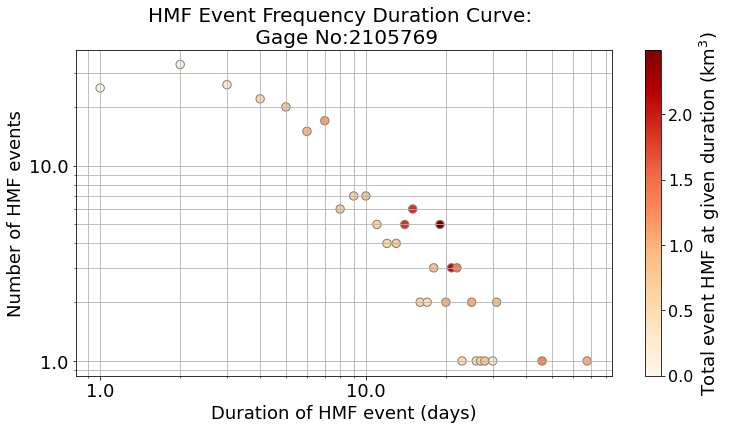

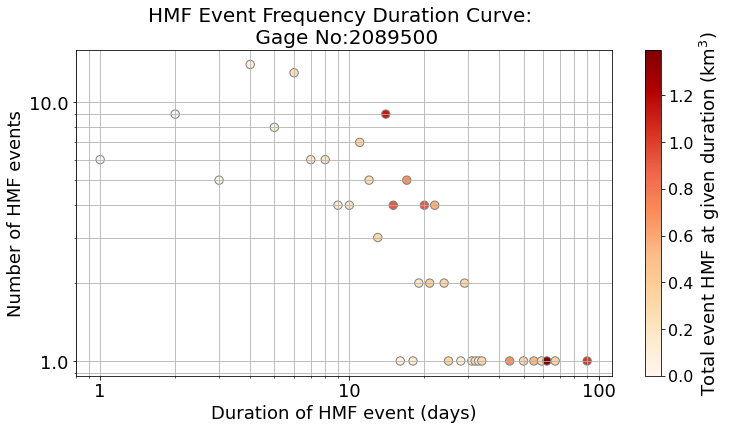

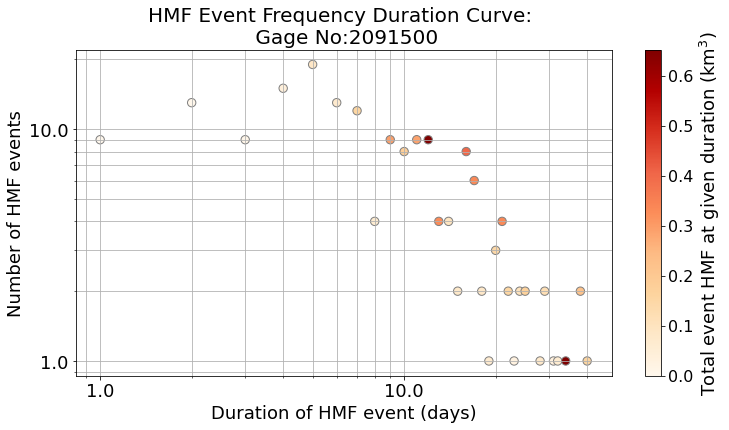

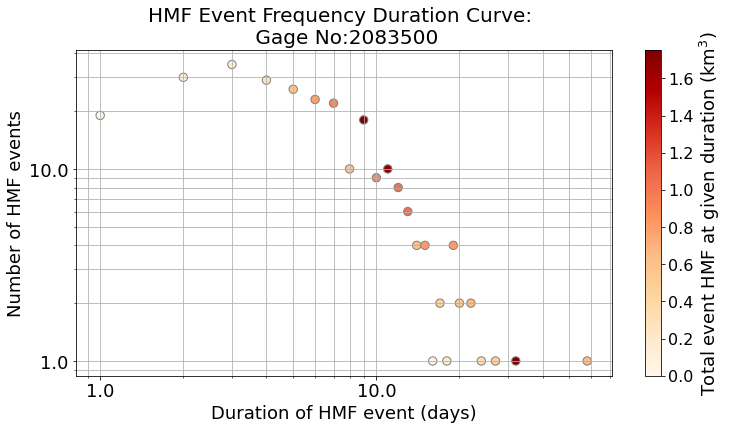

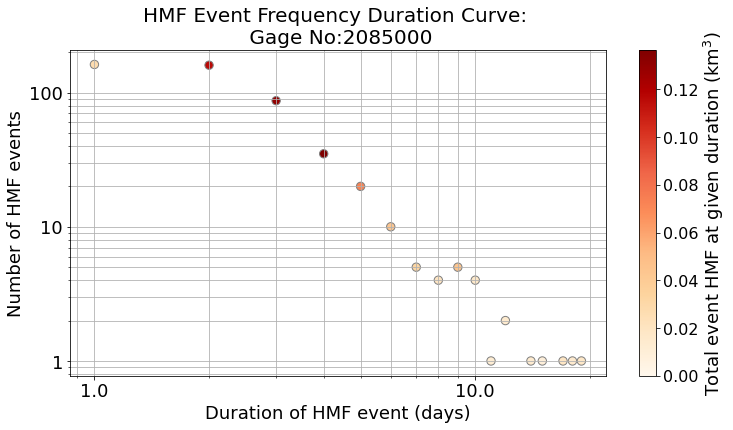

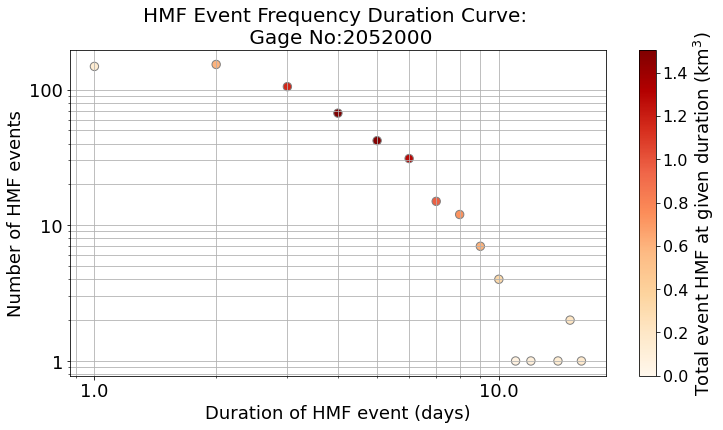

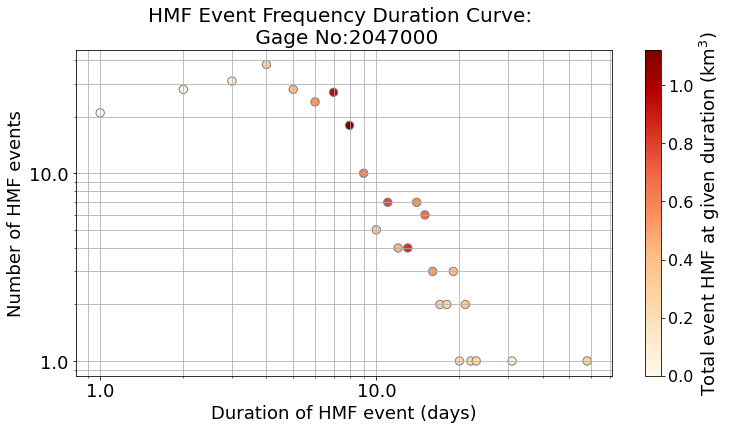

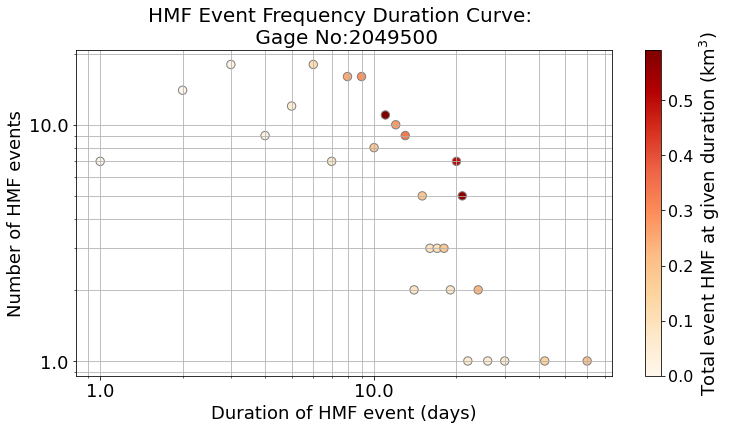

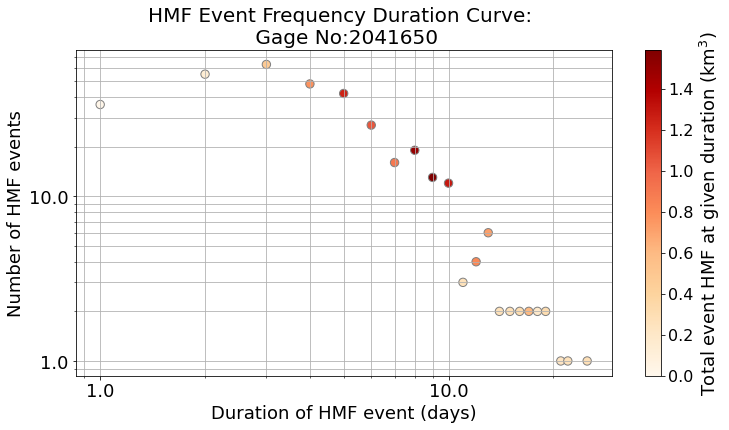

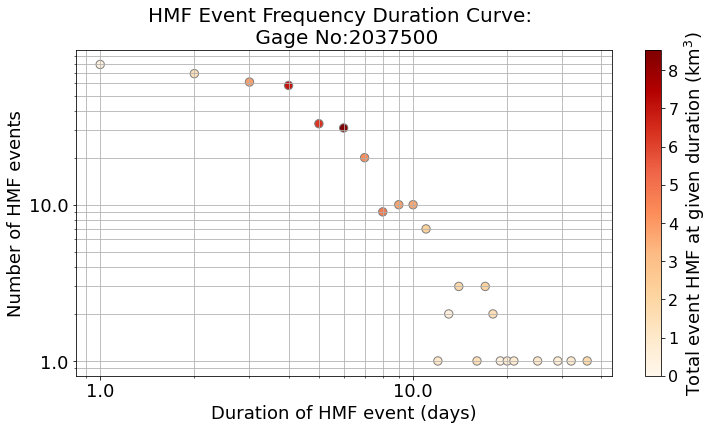

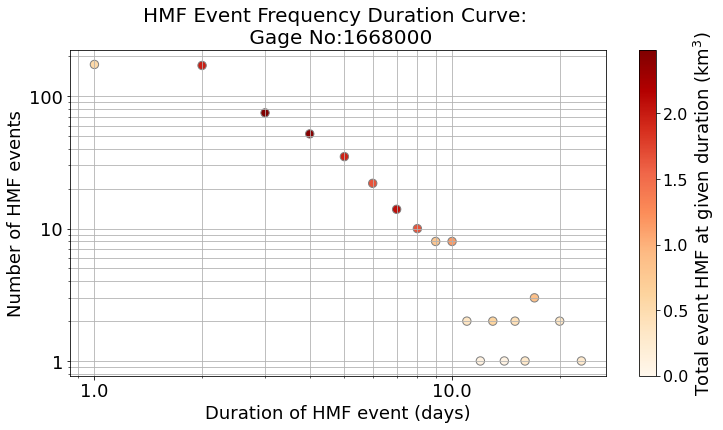

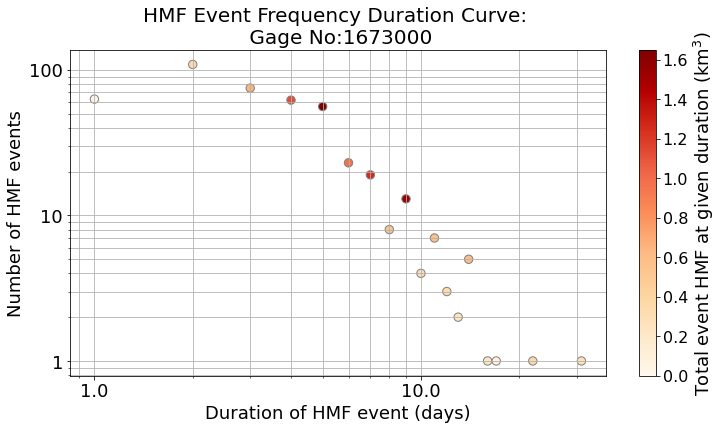

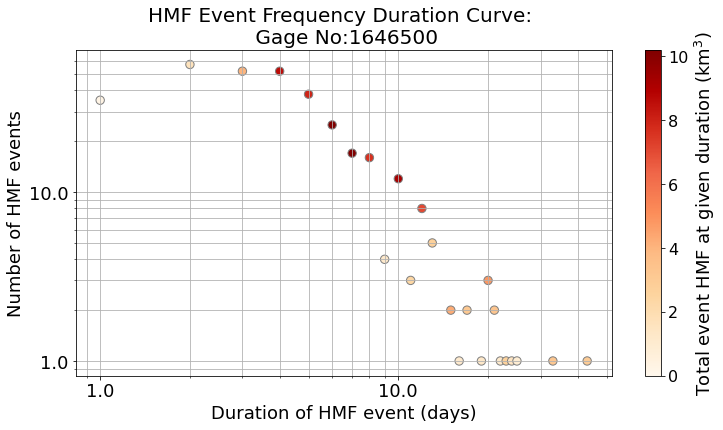

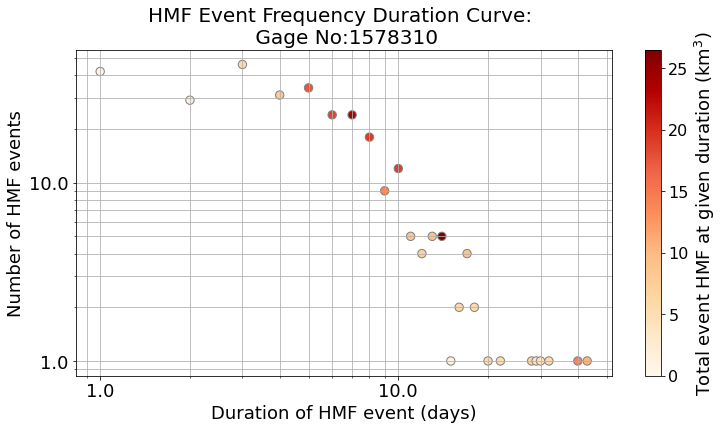

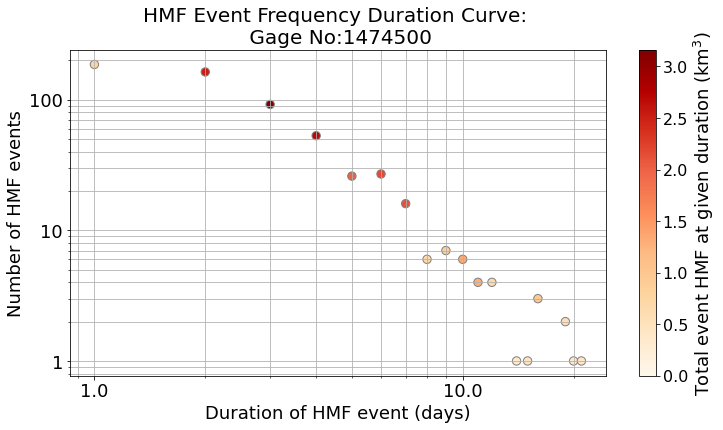

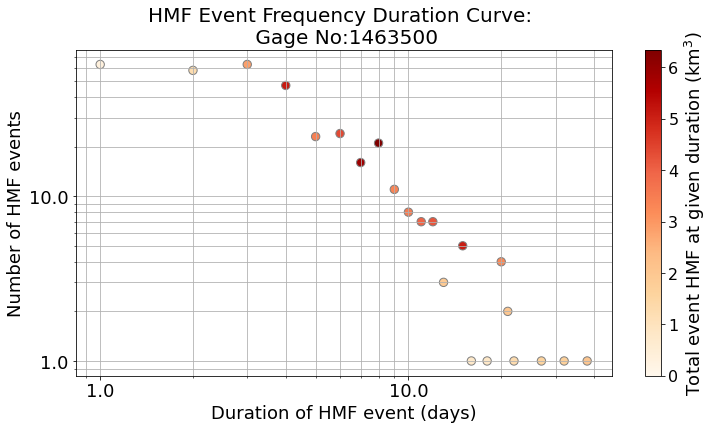

In [104]:
# Plot FDCs for gages in a given aquifer
# aq = 'cv'
for gage in outlet_gages_dict[aq]:
    df = sort_events(events_by_aq_dict_50_90[aq][gage], by='sum')
    fdc_single_site(df, aq)

# Code to replicate Texas Gulf figure in Yang & Scanlon paper    
# texas_gages = ['08211000', '08188500', '08176500', '08164000', '08162000', '08116650', '08068000', '08066500', '08033500', '08030500'] #'08116650',
# for gage in texas_gages:
#     aq = 'tg'
#     df = sort_events(events_by_aq_dict_50_90['cl'][gage])
#     fdc_single_site(df, aq)

### Generate and plot FDCs for all outlet gages by aquifer

In [87]:
# Store outlet events for each aquifer in a dictionary
grouped_aq_events_dict_50_90 = {}
for aq in aq_codes:
    df_aq = pd.DataFrame()
    for gage in outlet_gages_dict[aq]:
        df_events_gages_sort = sort_events(events_by_aq_dict_50_90[aq][gage], by='sum')
        df_aq = df_aq.append(df_events_gages_sort)
    grouped_df_aq = df_aq.groupby('duration').sum().reset_index()
    grouped_aq_events_dict_50_90[aq] = grouped_df_aq

# Texas coastal aquifers
df_texas_gages_50_90 = pd.DataFrame()
for gage in texas_gages:
    df_events_gages_sort = sort_events(events_by_aq_dict_50_90['cl'][gage], by='sum')
    df_texas_gages_50_90 = df_texas_gages_50_90.append(df_events_gages_sort)
df_texas_gages_grouped_50_90 = df_texas_gages_50_90.groupby('duration').sum().reset_index()
    
# # Central valley aquifers
# df_cv_gages_50_90 = pd.DataFrame()
# for gage in cv_outlet_gages:
#     df_events_gages_sort = sort_events(events_by_aq_dict_50_90['cv'][gage], by='sum')
#     df_cv_gages_50_90 = df_cv_gages_50_90.append(df_events_gages_sort)
    
# df_cv_gages_grouped_50_90 = df_cv_gages_50_90.groupby('duration').sum().reset_index()

In [89]:
#grouped_aq_events_dict_50_90

In [98]:
import matplotlib.ticker as mticker

def fdc_events(df, aq):
    df_plot = df

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

    cm = plt.cm.get_cmap('OrRd')
    scatter = ax.scatter(df_plot['duration'], df_plot['count'], c=df_plot['hmf'], vmin=0, vmax=df_plot['hmf'].max(), s=70, cmap=cm, edgecolors='grey')

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Total event HMF at given duration ($\mathregular{km^3}$)', fontsize=20)
    cbar.ax.tick_params(labelsize=16)

    ax.set_xlabel('Duration of HMF event (days)', fontsize=20)
    ax.set_ylabel('Number of HMF events', fontsize=20)
    if aq == 'Texas Gulf':
        ax.set_title(f'HMF Event Frequency Duration Curve: \n {aq}', fontsize=24)
    else:
        ax.set_title(f'HMF Event Frequency Duration Curve: \n {aq_names_10[aq]}', fontsize=24)

    plt.xscale("log")
    plt.yscale("log")

    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)
    #ax.mticker.FormatStrFormatter('%d')

    plt.grid('True', which="both", ls="-")
    
    plt.tick_params(axis='both', which='major', labelsize=18)

    img_path = f'Saved_Visuals/Aquifers/fre_dur_curve/fdc_{aq}.png'
    fn.save_plot_as_image(img_path, overwrite=True) 

    plt.show()

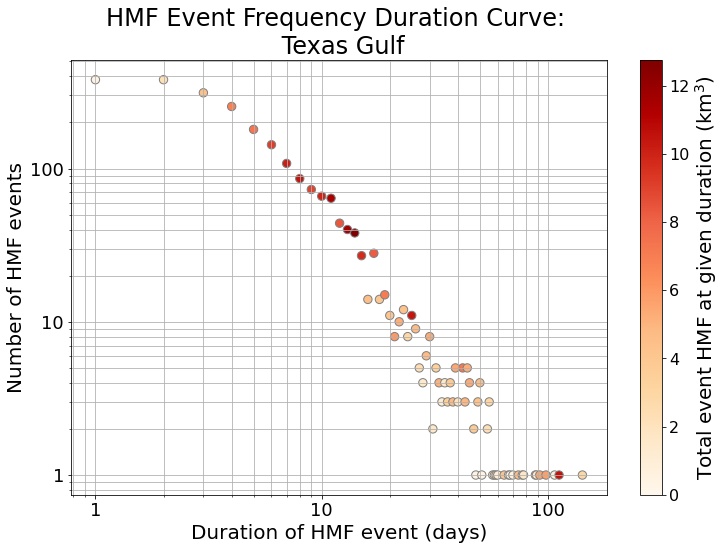

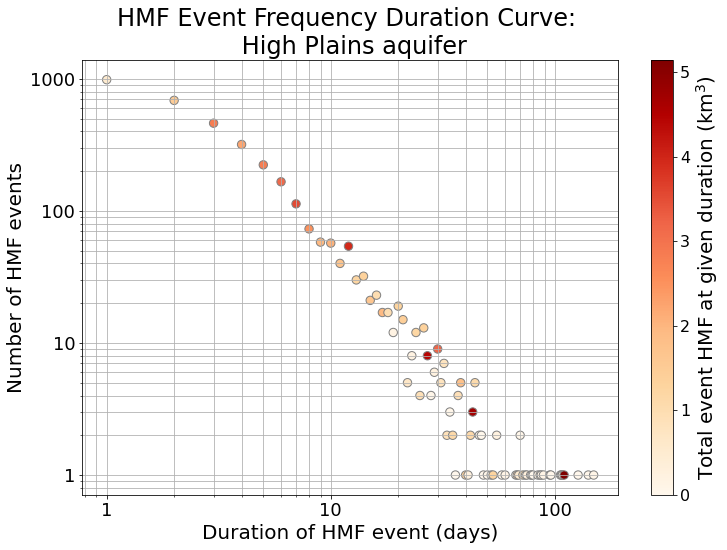

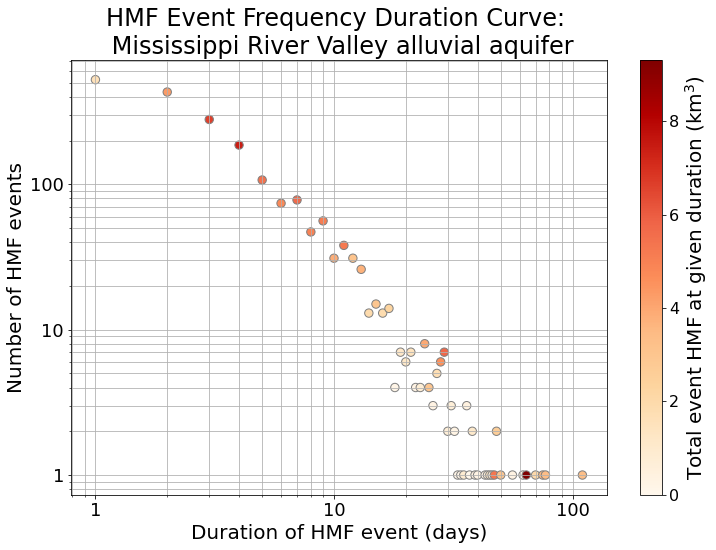

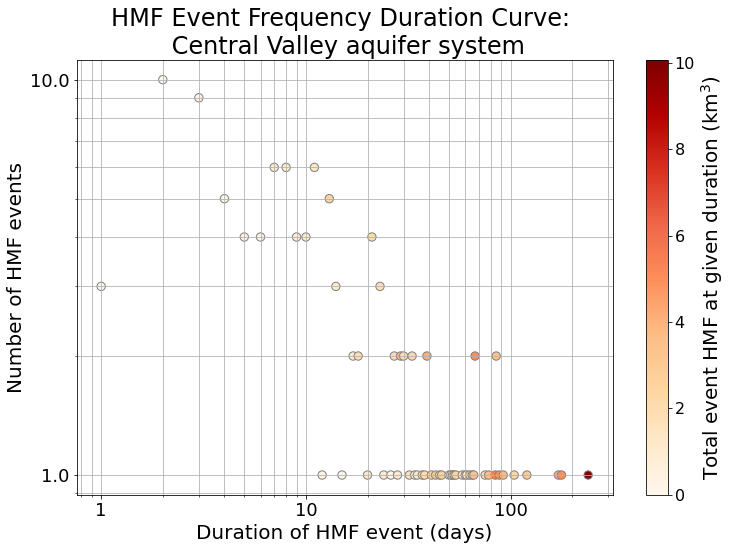

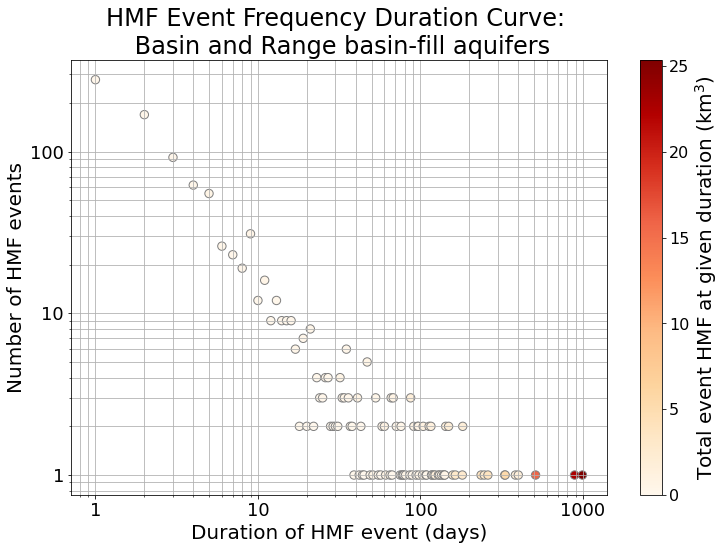

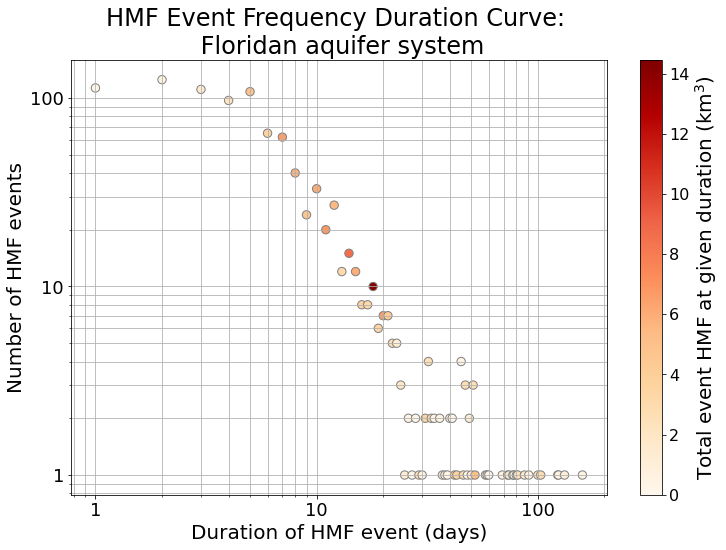

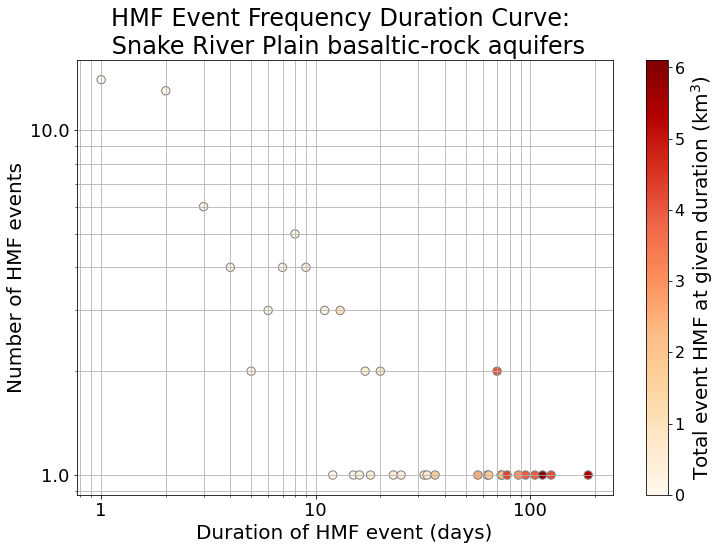

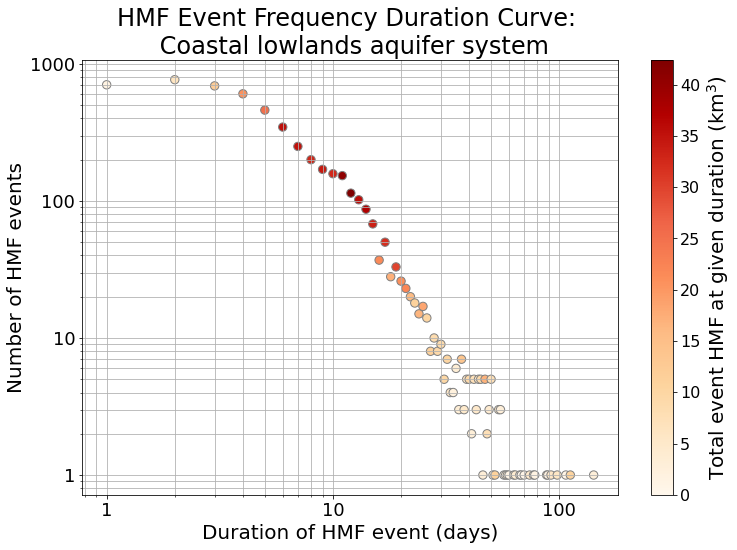

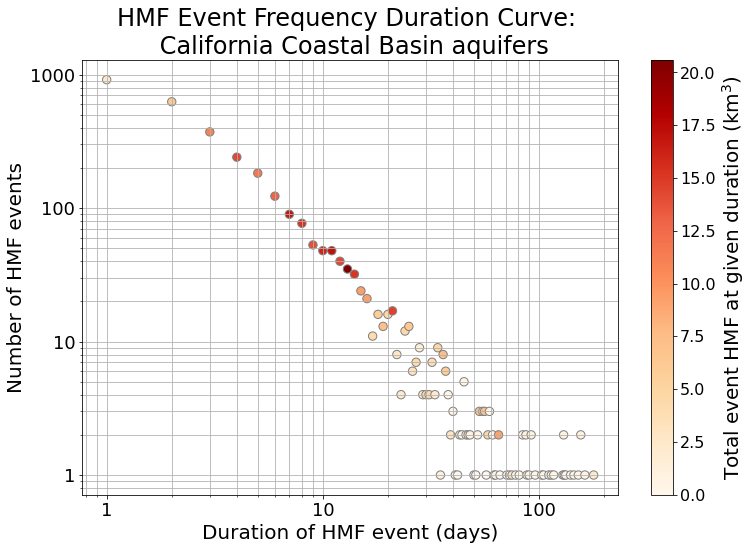

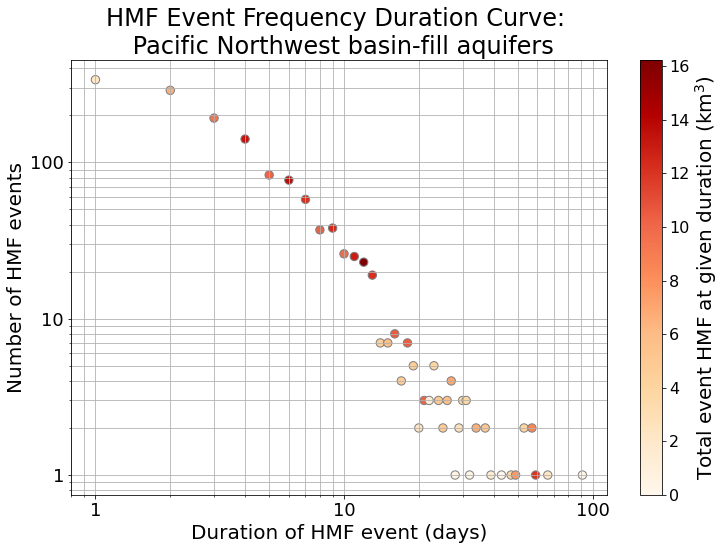

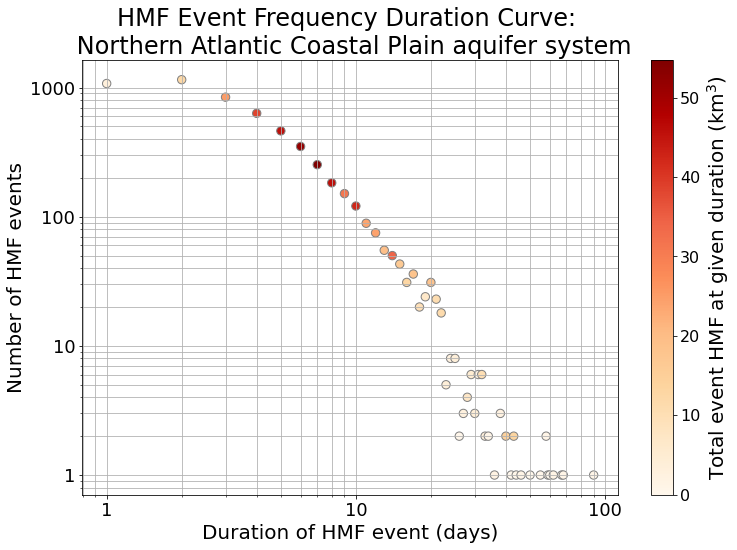

In [101]:
aq = 'Texas Gulf'
fdc_events(df_texas_gages_grouped_50_90, aq)

for aq in aq_codes:
    df = grouped_aq_events_dict_50_90[aq]
    fdc_events(df, aq)

In [90]:
combined_events_by_aq_dict = {}
for aq in aq_codes:
    aq_dict = events_by_aq_dict[aq]
    df_events_gages = pd.DataFrame()
    for site in aq_dict.keys():
        df = aq_dict[site]
        df_events_gages_sort = sort_events(df)
        df_events_gages = df_events_gages.append(df_events_gages_sort)
    combined_events_by_aq_dict[aq] = df_events_gages

In [22]:
aq_list_10 = ['High Plains aquifer',
                'Mississippi River Valley alluvial aquifer',
                'Central Valley aquifer system',
                'Basin and Range basin-fill aquifers',
                'Floridan aquifer system',
                'Snake River Plain basaltic-rock aquifers',
                'Coastal lowlands aquifer system',
                'California Coastal Basin aquifers', 
                'Pacific Northwest basin-fill aquifers',
                'Northern Atlantic Coastal Plain aquifer system']

In [75]:
import matplotlib.ticker as mticker

def fdc_events(df, i):
    df_plot = df

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

    cm = plt.cm.get_cmap('OrRd')
    scatter = ax.scatter(df_plot['duration'], df_plot['count'], c=df_plot['hmf'], vmin=0, vmax=df_plot['hmf'].max(), s=70, cmap=cm, edgecolors='grey')

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Total event HMF at given duration ($\mathregular{km^3}$)', fontsize=20)
    cbar.ax.tick_params(labelsize=16)

    ax.set_xlabel('Duration of HMF event (days)', fontsize=20)
    ax.set_ylabel('Number of HMF events', fontsize=20)
    ax.set_title(f'HMF Event Frequency Duration Curve: \n {aq_list_10[i]}', fontsize=24)

    plt.xscale("log")
    plt.yscale("log")

    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)
    #ax.mticker.FormatStrFormatter('%d')

    plt.grid('True', which="both", ls="-")
    
    plt.tick_params(axis='both', which='major', labelsize=18)

    img_path = f'Saved_Visuals/Aquifers/fre_dur_curve/fdc_{aq}.png'
    fn.save_plot_as_image(img_path, overwrite=True) 

    plt.show()
    
for i, aq in enumerate(aq_codes):
    df = combined_events_by_aq_dict[aq]
    fdc_events(df, i)

NameError: name 'combined_events_by_aq_dict' is not defined

## Annual metrics timeseries for valid gages

In [22]:
import pyarrow.parquet as pq
annual_metrics_df = pq.read_table('Prelim_Data/annual_metrics_subdf_30_90.parquet')

In [25]:
annual_metrics_df = annual_metrics_df.to_pandas()

In [26]:
annual_metrics_df

AttributeError: 'NoneType' object has no attribute 'items'

     site_no  water_year  annual_hmf  annual_duration  event_hmf  \
0   02342500        1990    0.092031             29.0   0.010226   
1   02342500        1991    0.067863             37.0   0.009695   
2   02342500        1992    0.125069             56.0   0.007817   
3   02342500        1993    0.164619             42.0   0.016462   
4   02342500        1994    0.048014             23.0   0.006002   
..       ...         ...         ...              ...        ...   
25  13018300        2015    0.000051             14.0   0.000013   
26  13018300        2016    0.007294             77.0   0.007294   
27  13018300        2017    0.003553             56.0   0.003553   
28  13018300        2018    0.001694             46.0   0.000847   
29  13018300        2019    0.001353             35.0   0.000338   

    event_duration  total_events  timing  
0         3.222222           9.0   181.0  
1         5.285714           7.0   137.0  
2         3.500000          16.0    58.0  
3         4

In [52]:
gage_no = 11447650
df_gage = annual_metrics_df[annual_metrics_df['site_no'] == str(gage_no)]
cols = ['annual_hmf', 'annual_duration', 'event_hmf', 'event_duration', 'total_events', 'timing']
for col in cols:
    value = df_gage[df_gage[col] != 0][col].mean()
    print(col, round(value, 7))

annual_hmf 2.6324419
annual_duration 54.6
event_hmf 1.0337324
event_duration 20.7608333
total_events 2.7
timing 144.6


In [53]:
df_30_90 = dfs_valid['30_90']
df_30_90[df_30_90['site_no'] == gage_no].transpose()
#df_30_90[df_30_90['site_no'] == '13335050']
#dfs_valid['30_90'][dfs_valid['30_90'][['site_no'] == '11447650']]

AttributeError: 'NoneType' object has no attribute 'items'

                                           784
site_no                               11447650
analyze_start              1990-10-01 00:00:00
analyze_end                2020-09-30 00:00:00
analyze_range                               30
quantile                                   0.9
valid                                     True
missing_data%                                0
threshold                                48800
hmf_years                                   20
annual_hmf                             2.63244
six_mo_hmf                             2.44089
three_mo_hmf                           1.37305
annual_duration                           54.6
event_duration                         20.7608
event_hmf                              1.03373
inter_annual%                           66.667
intra_annual                               2.7
timing                                   144.6
jan_hmf                               0.634699
feb_hmf                                1.18156
mar_hmf      